In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [9]:
import nltk
import gensim
import re
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint
# Figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

os.environ['MALLET_HOME']='mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

# TODO
* change to (2000,2021)
* append authors
* fix blankspace problem with authors in USENIX

## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [10]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [11]:
testCorpus = ['Critical infrastructure, including the Internet, plays a vital role in the economic, political, and social fabric of society.',
              'In many software attacks, inducing an illegal control-flow transfer in the target system is one common step.',
              'This paper evaluates whether CFI-enabled static analysis can help build efficient and validated data sandboxing.',
              'Canettis universal composition theorem and the joint state composition theorems by Canetti and Rabin are useful.',
              'In this paper we examine composability properties for the fundamental task of key exchange.']
testCorpus

['Critical infrastructure, including the Internet, plays a vital role in the economic, political, and social fabric of society.',
 'In many software attacks, inducing an illegal control-flow transfer in the target system is one common step.',
 'This paper evaluates whether CFI-enabled static analysis can help build efficient and validated data sandboxing.',
 'Canettis universal composition theorem and the joint state composition theorems by Canetti and Rabin are useful.',
 'In this paper we examine composability properties for the fundamental task of key exchange.']

In [12]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda z: remove_stopwords(z)          # Removes stopwords 
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

In [13]:
cleanTestCorpus = [clean_doc(doc) for doc in testCorpus]
cleanTestCorpus

[['critical',
  'infrastructure',
  'include',
  'internet',
  'play',
  'vital',
  'role',
  'economic',
  'political',
  'social',
  'fabric',
  'society'],
 ['software',
  'attack',
  'induce',
  'illegal',
  'control',
  'flow',
  'transfer',
  'target',
  'common',
  'step'],
 ['paper',
  'evaluate',
  'enabled',
  'static',
  'analysis',
  'help',
  'build',
  'efficient',
  'validated',
  'data',
  'sandboxing'],
 ['canettis',
  'universal',
  'composition',
  'theorem',
  'joint',
  'state',
  'composition',
  'theorem',
  'canetti',
  'rabin',
  'useful'],
 ['paper',
  'examine',
  'composability',
  'property',
  'fundamental',
  'task',
  'exchange']]

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [15]:
bigram = gensim.models.Phrases(cleanTestCorpus, min_count=5, threshold=1) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

cleanBigramTestCorpus = make_bigrams(cleanTestCorpus)
cleanBigramTestCorpus

[['critical',
  'infrastructure',
  'include',
  'internet',
  'play',
  'vital',
  'role',
  'economic',
  'political',
  'social',
  'fabric',
  'society'],
 ['software',
  'attack',
  'induce',
  'illegal',
  'control',
  'flow',
  'transfer',
  'target',
  'common',
  'step'],
 ['paper',
  'evaluate',
  'enabled',
  'static',
  'analysis',
  'help',
  'build',
  'efficient',
  'validated',
  'data',
  'sandboxing'],
 ['canettis',
  'universal',
  'composition',
  'theorem',
  'joint',
  'state',
  'composition',
  'theorem',
  'canetti',
  'rabin',
  'useful'],
 ['paper',
  'examine',
  'composability',
  'property',
  'fundamental',
  'task',
  'exchange']]

### Splitting the corpus and making it into a dictionary

In [16]:
dictionary = corpora.Dictionary(cleanBigramTestCorpus)
print(dictionary)
testM1 = [dictionary.doc2bow(doc) for doc in cleanBigramTestCorpus]
testM1

Dictionary(48 unique tokens: ['critical', 'economic', 'fabric', 'include', 'infrastructure']...)


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1)],
 [(12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1)],
 [(22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1)],
 [(33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1)],
 [(29, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]]

## LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [22]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=testM1,
                                             num_topics=4,
                                             id2word=dictionary)
ldamallet

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=cleanBigramTestCorpus,
                                           dictionary=dictionary, 
                                           coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('theorem', 0.18181818181818182),
   ('rabin', 0.09090909090909091),
   ('target', 0.09090909090909091),
   ('task', 0.09090909090909091),
   ('state', 0.09090909090909091),
   ('social', 0.09090909090909091),
   ('induce', 0.09090909090909091),
   ('fundamental', 0.09090909090909091),
   ('economic', 0.09090909090909091),
   ('control', 0.09090909090909091)]),
 (1,
  [('paper', 0.13333333333333333),
   ('composition', 0.13333333333333333),
   ('examine', 0.06666666666666667),
   ('enabled', 0.06666666666666667),
   ('sandboxing', 0.06666666666666667),
   ('build', 0.06666666666666667),
   ('attack', 0.06666666666666667),
   ('evaluate', 0.06666666666666667),
   ('role', 0.06666666666666667),
   ('exchange', 0.06666666666666667)]),
 (2,
  [('universal', 0.08333333333333333),
   ('transfer', 0.08333333333333333),
   ('canettis', 0.08333333333333333),
   ('critical', 0.08333333333333333),
   ('step', 0.08333333333333333),
   ('vital', 0.08333333333333333),
   ('society', 0.083333

In [29]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

lda_mallet_model = mallet_to_lda(ldamallet)
print(lda_mallet_model)

LdaModel(num_terms=48, num_topics=4, decay=0.5, chunksize=2000)


In [27]:
print(dictionary)

Dictionary(48 unique tokens: ['critical', 'economic', 'fabric', 'include', 'infrastructure']...)


In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, testM1, dictionary)
vis

TypeError: unhashable type: 'Int64Index'

## Setting upp the lda model
Used insted of LDA mallet

In [26]:
Lda = gensim.models.ldamodel.LdaModel
lda_model = Lda(tfidf_M1, 
                num_topics=2, 
                id2word = dictionary, 
                passes=18, 
                random_state =0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Multicore

In [27]:
Lda = gensim.models.ldamulticore.LdaMulticore
lda_model = Lda(tfidf_M1 , 
                num_topics=8, 
                id2word = dictionary, 
                passes=15,
                random_state =0,
                workers=4)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=corpus_clean_bigram, 
                                     dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.6364102700593359


In [25]:
topics = lda_model.print_topics(num_topics=100, num_words=6)

for topic in topics:
    print(topic)

(0, '0.001*"abstract" + 0.001*"available" + 0.001*"flash" + 0.001*"rpki" + 0.001*"skimmer" + 0.001*"walkie_talkie"')
(1, '0.001*"helios" + 0.001*"prêt_voter" + 0.001*"volte" + 0.001*"coercion" + 0.001*"sanctum" + 0.001*"guis"')
(2, '0.002*"captchas" + 0.001*"rust" + 0.001*"captcha" + 0.001*"pill" + 0.001*"spurious" + 0.000*"macs"')
(3, '0.002*"workshop" + 0.001*"proverif" + 0.001*"quic" + 0.001*"meltdown" + 0.001*"protocol" + 0.001*"snarks"')
(4, '0.002*"rowhammer" + 0.001*"deduplication" + 0.001*"printer" + 0.001*"uninitialized" + 0.001*"spamming" + 0.001*"spammer"')
(5, '0.004*"attack" + 0.003*"user" + 0.003*"protocol" + 0.003*"data" + 0.003*"security" + 0.002*"network"')
(6, '0.001*"recommender" + 0.001*"bliss" + 0.001*"sdns" + 0.001*"journalist" + 0.000*"fake_visitations" + 0.000*"court"')
(7, '0.001*"vault" + 0.001*"crowdturfing" + 0.001*"fitness" + 0.001*"compartmentalization" + 0.001*"kerberos" + 0.001*"ethos"')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualisation of topics
First creating a lda mallet model and then visualising

In [47]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [15]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.039249  0.264450       1        1  7.928572
3     -0.049214  0.005006       2        1  7.829685
5      0.289329 -0.067325       3        1  7.822919
9     -0.151208  0.030695       4        1  7.796050
1     -0.095397  0.232182       5        1  7.746311
6     -0.082588 -0.174404       6        1  7.745824
7     -0.145265 -0.157413       7        1  7.684446
11     0.157578  0.095969       8        1  7.670407
0      0.092626 -0.176711       9        1  7.579987
10     0.053340  0.063380      10        1  7.579687
8      0.201543 -0.065595      11        1  7.578054
4     -0.142233  0.059713      12        1  7.542720
12    -0.167759 -0.109948      13        1  7.495338, topic_info=              Term         Freq        Total Category  logprob  loglift
200         attack  4887.000000  4887.000000  Default  30.0000  30.0000
14            data  3088.000000  3088.000000  Default  29.0000  29.0000
196           user  3244.000000  3244.000000  Default  28.0000  28.0000
379        network  1971.000000  1971.000000  Default  27.0000  27.0000
525        privacy  1896.000000  1896.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
259        achieve   164.287516   615.488553  Topic13  -5.0913   1.2701
11            cost   154.875210   434.854721  Topic13  -5.1503   1.5585
625        require   158.297867   847.347704  Topic13  -5.1285   0.9133
78   communication   155.730875   608.013000  Topic13  -5.1448   1.2288
194           time   156.586539  1257.003063  Topic13  -5.1393   0.5080

[1037 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         8  0.996734           abuse
357       7  0.080792          access
357       9  0.919115          access
546       9  1.043400      accidental
70        3  0.998615         account
...     ...       ...             ...
636      13  0.206218            work
1413      7  1.004997        workload
1318     11  0.310320           write
1318     12  0.689016           write
2657     13  0.996818  zero_knowledge

[1512 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 10, 2, 7, 8, 12, 1, 11, 9, 5, 13])

# Panda

In [16]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_mallet_model, corpus=M1, texts=corpus_clean_bigram)


## Topic distribution over all documents

In [23]:
def topic_distribution(ldamodel, corpus, texts):
    topicPercent = []
    topicNumbers = []
    numberOfTopics = 0
    topicNames = []
    
    # Get all topics in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Counts number of topics
        if i==0:
            numberOfTopics = len(row)
        topicPercent = []
        for topicNr, topicDistribution in row:
            topicPercent.append(topicDistribution)
        topicNumbers.append(topicPercent)

    dataframe = pd.DataFrame(topicNumbers)
    
    # Create names for each topic
    for i in range (0, numberOfTopics):
        topicName = 'Topic_' + str(i)
        topicNames.append(topicName)
        
    # Set all column lables
    dataframe.columns = topicNames
    
    return(dataframe)

topic_distribution_df = topic_distribution(ldamodel=lda_mallet_model, corpus=M1, texts=corpus_clean_bigram)
topic_distribution_df


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12
0,0.077172,0.080629,0.076456,0.075547,0.077825,0.075961,0.078729,0.075796,0.075146,0.074738,0.076559,0.077841,0.077602
1,0.073944,0.081106,0.083035,0.078809,0.079535,0.078746,0.080999,0.077734,0.073258,0.072474,0.071537,0.076400,0.072422
2,0.072140,0.075345,0.083329,0.078099,0.075113,0.078868,0.081336,0.076966,0.080733,0.081997,0.070885,0.072348,0.072842
3,0.080751,0.083295,0.082893,0.078398,0.074600,0.077855,0.076990,0.075214,0.078175,0.073319,0.073039,0.070594,0.074877
4,0.078115,0.072692,0.068787,0.082559,0.109485,0.065066,0.075339,0.071095,0.079862,0.078026,0.066893,0.070946,0.081135
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,0.079526,0.088666,0.077415,0.082398,0.068759,0.078929,0.084411,0.067617,0.073622,0.073555,0.073834,0.077127,0.074141
3690,0.076192,0.069643,0.089176,0.095104,0.087768,0.087128,0.072132,0.069159,0.059135,0.069362,0.068615,0.092398,0.064188
3691,0.070002,0.080486,0.074877,0.077613,0.082735,0.090676,0.071423,0.087114,0.070726,0.065793,0.080345,0.089710,0.058500
3692,0.085035,0.080269,0.076994,0.077633,0.071944,0.075293,0.072475,0.074112,0.074690,0.078391,0.081233,0.076439,0.075492


## Topics per document
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.



In [18]:
lda_mallet_model.get_document_topics(M1[1],minimum_probability=0)

[(0, 0.07393935),
 (1, 0.08116977),
 (2, 0.08303881),
 (3, 0.078818895),
 (4, 0.07949836),
 (5, 0.07875604),
 (6, 0.08099026),
 (7, 0.07770893),
 (8, 0.07326224),
 (9, 0.072481595),
 (10, 0.071538515),
 (11, 0.07638939),
 (12, 0.07240778)]

In [19]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.0806,"model, password, input, algorithm, method, app...","[online, sale, counterfeit, unauthorized, prod..."
1,1,2.0,0.0830,"analysis, malware, detect, malicious, approach...","[traditional, spam, detection, rely, content, ..."
2,2,2.0,0.0834,"analysis, malware, detect, malicious, approach...","[paper, quantify, effect, unsolicited, email, ..."
3,3,1.0,0.0833,"model, password, input, algorithm, method, app...","[explore, robustness, usability, moving, image..."
4,4,4.0,0.1095,"code, program, technique, flow, analysis, kern...","[help, user, create, strong, text, based, pass..."
5,5,5.0,0.0826,"user, security, study, research, online, risk,...","[provide, number, practical, technique, algori..."
6,6,7.0,0.0836,"channel, hardware, performance, software, memo...","[vulnerabilities, browser, extension, user, ri..."
7,7,9.0,0.0804,"data, privacy, information, query, propose, lo...","[browser, mediate, access, valuable, private, ..."
8,8,4.0,0.0863,"code, program, technique, flow, analysis, kern...","[cryptographic, rely, secrecy, cryptographic, ..."
9,9,3.0,0.0821,"network, traffic, server, client, internet, co...","[brain, interface, increasingly, popular, gami..."


In [22]:
corpus[6]

'Vulnerabilities in browser extensions put users at risk by providing a way for website and network attackers to gain access to users’ private data and credentials. Extensions can also introduce vulnerabilities into the websites that they modify. In 2009, Google Chrome introduced a new extension platform with several features intended to prevent and mitigate extension vulnerabilities: strong isolation between websites and extensions, privilege separation within an extension, and an extension permission system. We performed a security review of 100 Chrome extensions and found 70 vulnerabilities across 40 extensions. Given these vulnerabilities, we evaluate how well each of the security mechanisms defends against extension vulnerabilities. We find that the mechanisms mostly succeed at preventing web attacks, but new security mechanisms are needed to protect users from network attacks on extensions, website metadata attacks on extensions, and vulnerabilities that extensions add to website

## Most representative document per topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [20]:
# Group top 5 corpuses under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0964,"user, application, access, policy, android, co...","[mobile, apps, include, privacy, setting, allo..."
1,1.0,0.1027,"model, password, input, algorithm, method, app...","[bluetooth, widely, communication, technology,..."
2,2.0,0.1274,"analysis, malware, detect, malicious, approach...","[voice, interface, accept, widely, input, meth..."
3,3.0,0.0968,"network, traffic, server, client, internet, co...","[modern, application, increasingly, rely, cont..."
4,4.0,0.1095,"code, program, technique, flow, analysis, kern...","[help, user, create, strong, text, based, pass..."
5,5.0,0.1041,"user, security, study, research, online, risk,...","[enterprises, significant, fraction, host, con..."
6,6.0,0.0980,"security, design, provide, propose, introduce,...","[memory_corruption, vulnerability, allow, modi..."
7,7.0,0.1032,"channel, hardware, performance, software, memo...","[paper, explore, problem, create, vulnerabilit..."
8,8.0,0.0922,"security, vulnerability, tool, browser, applic...","[real_world, social, network, decentralize, na..."
9,9.0,0.1069,"data, privacy, information, query, propose, lo...","[transport_layer, security, protocol, quickly,..."


## Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [21]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
dominant_topic_list = topic_counts.rename_axis('Dominant_Topic').reset_index(name='Num_Topics')

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
dominant_topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='Topics_Contribution')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords.reset_index(level=0, inplace=True)
topic_num_keywords.columns = ['Document_ID', 'Dominant_Topic', 'Topic_Keywords']

# Concatenate Column wise
df_dominant_topics_contribution = pd.merge(dominant_topic_list, dominant_topic_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])
df_dominant_topics = pd.merge(topic_num_keywords, df_dominant_topics_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])

# Sort by Document ID
df_dominant_topics = df_dominant_topics.sort_values(by=['Document_ID']).reset_index(drop=True).drop('Document_ID', axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Change to integer
df_dominant_topics['Dominant_Topic'] = df_dominant_topics['Dominant_Topic'].astype(np.int64)

# Add year and conference
df_document_per_topic = df_dominant_topics.join(df_year_conf)

# Show
df_document_per_topic

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Year,Conf
0,1,"model, password, input, algorithm, method, app...",364,0.0985,2012,Usenix
1,2,"analysis, malware, detect, malicious, approach...",621,0.1681,2012,Usenix
2,2,"analysis, malware, detect, malicious, approach...",621,0.1681,2012,Usenix
3,1,"model, password, input, algorithm, method, app...",364,0.0985,2012,Usenix
4,4,"code, program, technique, flow, analysis, kern...",158,0.0428,2012,Usenix
...,...,...,...,...,...,...
3689,1,"model, password, input, algorithm, method, app...",364,0.0985,2019,NDSS
3690,3,"network, traffic, server, client, internet, co...",434,0.1175,2019,NDSS
3691,5,"user, security, study, research, online, risk,...",437,0.1183,2019,NDSS
3692,0,"user, application, access, policy, android, co...",146,0.0395,2019,NDSS


### Now we want to group all documents from a specific year
Hur många artiklar från Usenix 2012 har topic x?

paper - author - year - Conference - topic1 - topic 2 - ... - topic N 


In [26]:
df = df_year_conf.join(topic_distribution_df)
df

,Year,Conf,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12
0,2012,Usenix,0.077172,0.080629,0.076456,0.075547,0.077825,0.075961,0.078729,0.075796,0.075146,0.074738,0.076559,0.077841,0.077602
1,2012,Usenix,0.073944,0.081106,0.083035,0.078809,0.079535,0.078746,0.080999,0.077734,0.073258,0.072474,0.071537,0.076400,0.072422
2,2012,Usenix,0.072140,0.075345,0.083329,0.078099,0.075113,0.078868,0.081336,0.076966,0.080733,0.081997,0.070885,0.072348,0.072842
3,2012,Usenix,0.080751,0.083295,0.082893,0.078398,0.074600,0.077855,0.076990,0.075214,0.078175,0.073319,0.073039,0.070594,0.074877
4,2012,Usenix,0.078115,0.072692,0.068787,0.082559,0.109485,0.065066,0.075339,0.071095,0.079862,0.078026,0.066893,0.070946,0.081135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,2019,NDSS,0.079526,0.088666,0.077415,0.082398,0.068759,0.078929,0.084411,0.067617,0.073622,0.073555,0.073834,0.077127,0.074141
3690,2019,NDSS,0.076192,0.069643,0.089176,0.095104,0.087768,0.087128,0.072132,0.069159,0.059135,0.069362,0.068615,0.092398,0.064188
3691,2019,NDSS,0.070002,0.080486,0.074877,0.077613,0.082735,0.090676,0.071423,0.087114,0.070726,0.065793,0.080345,0.089710,0.058500
3692,2019,NDSS,0.085035,0.080269,0.076994,0.077633,0.071944,0.075293,0.072475,0.074112,0.074690,0.078391,0.081233,0.076439,0.075492


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12
Year,,,,,,,,,,,,,
2000,0.076177,0.077701,0.077510,0.077872,0.076103,0.077149,0.076638,0.075895,0.076599,0.078065,0.077453,0.076423,0.076416
2001,0.076960,0.078459,0.079516,0.077950,0.075982,0.077014,0.077741,0.077632,0.075594,0.076704,0.074937,0.076665,0.074846
2002,0.076572,0.076947,0.077443,0.078399,0.075955,0.077921,0.078285,0.075990,0.076420,0.077864,0.076439,0.076770,0.074993
2003,0.076127,0.077314,0.077246,0.078116,0.076036,0.079299,0.078514,0.076888,0.077166,0.075828,0.076871,0.075271,0.075322
2004,0.075809,0.076977,0.078750,0.078249,0.075890,0.079267,0.076869,0.075828,0.076060,0.076633,0.076631,0.077911,0.075124
2005,0.076526,0.078768,0.078941,0.078337,0.074422,0.080202,0.077539,0.077941,0.075399,0.075562,0.076500,0.075917,0.073948
2006,0.076240,0.078242,0.079239,0.077964,0.074619,0.078070,0.077462,0.077392,0.075533,0.077683,0.075865,0.076927,0.074763
2007,0.075717,0.077378,0.079792,0.077223,0.075701,0.077780,0.078466,0.077310,0.076666,0.076191,0.076420,0.076681,0.074675
2008,0.077149,0.077165,0.078333,0.076899,0.075883,0.077566,0.077812,0.078614,0.076254,0.077059,0.075713,0.076606,0.074947


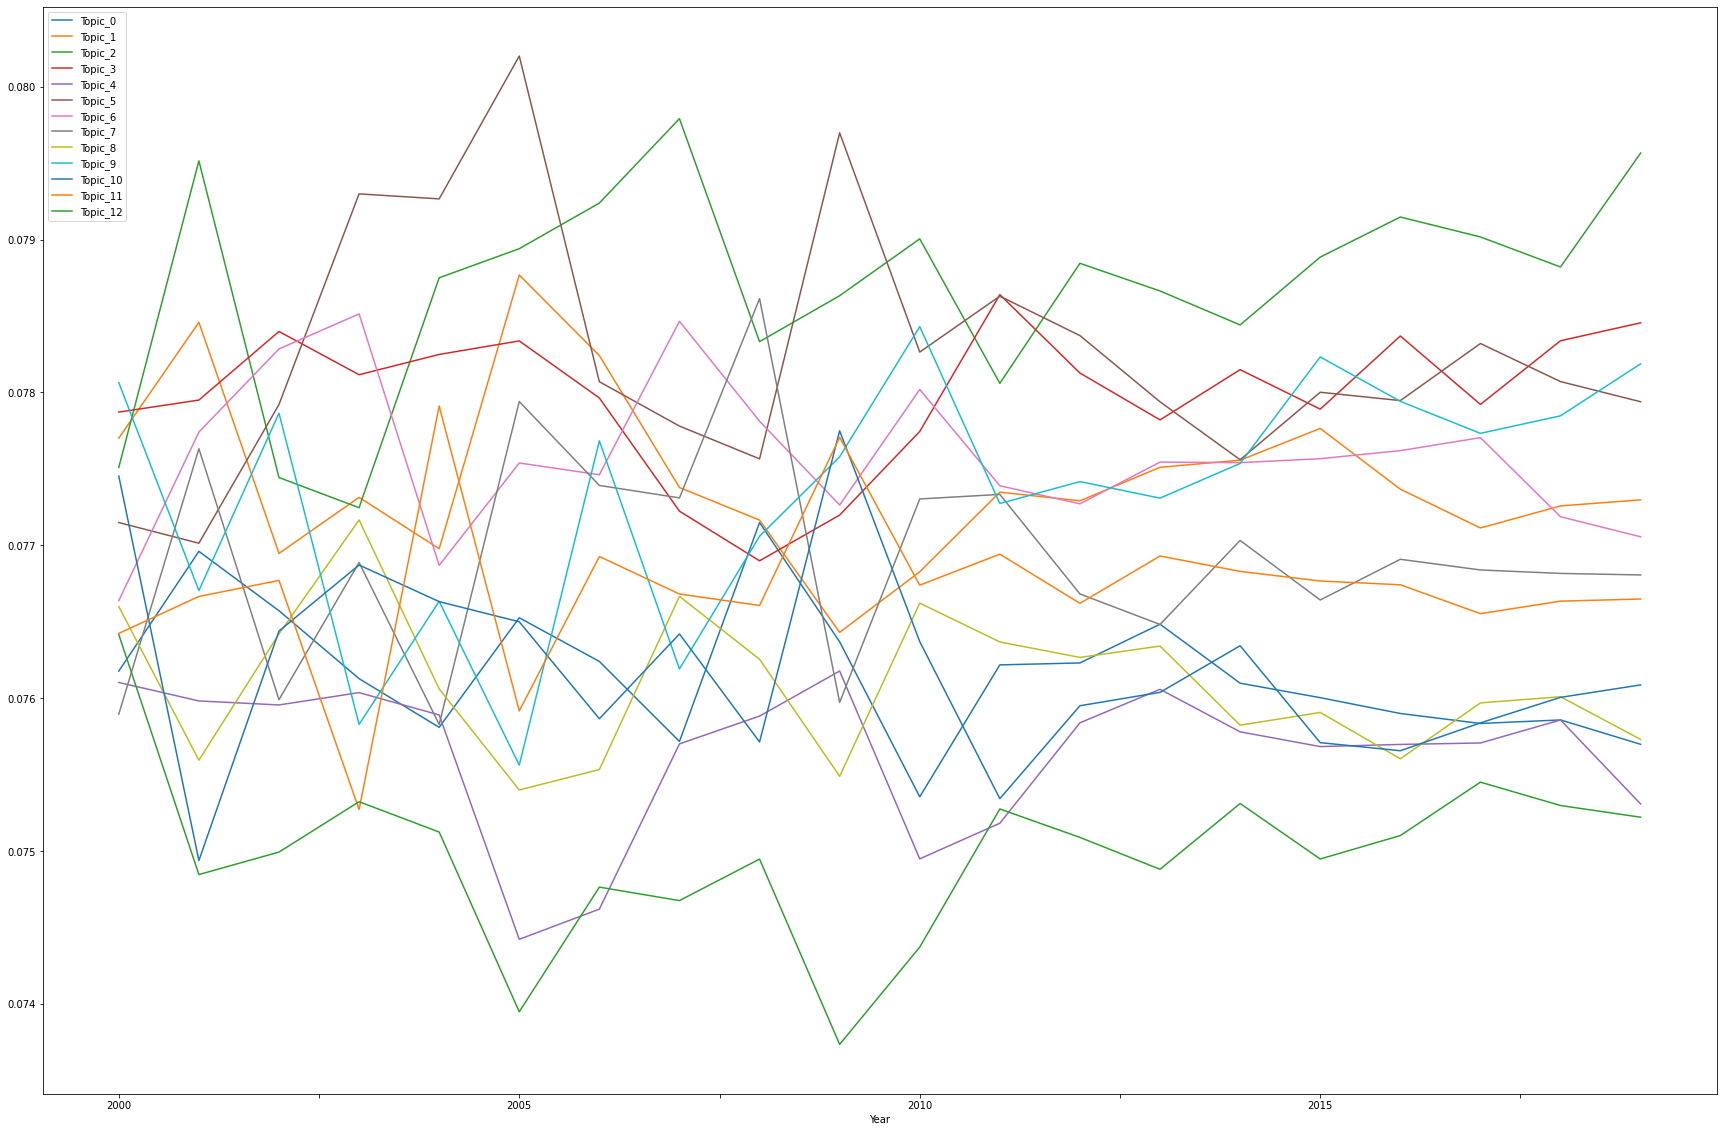

In [51]:
# Topic distribution over year graph
df_joined_year = df.groupby(['Year']).mean()
df_joined_year.plot(figsize=(30,20))
df_joined_year

<AxesSubplot:>

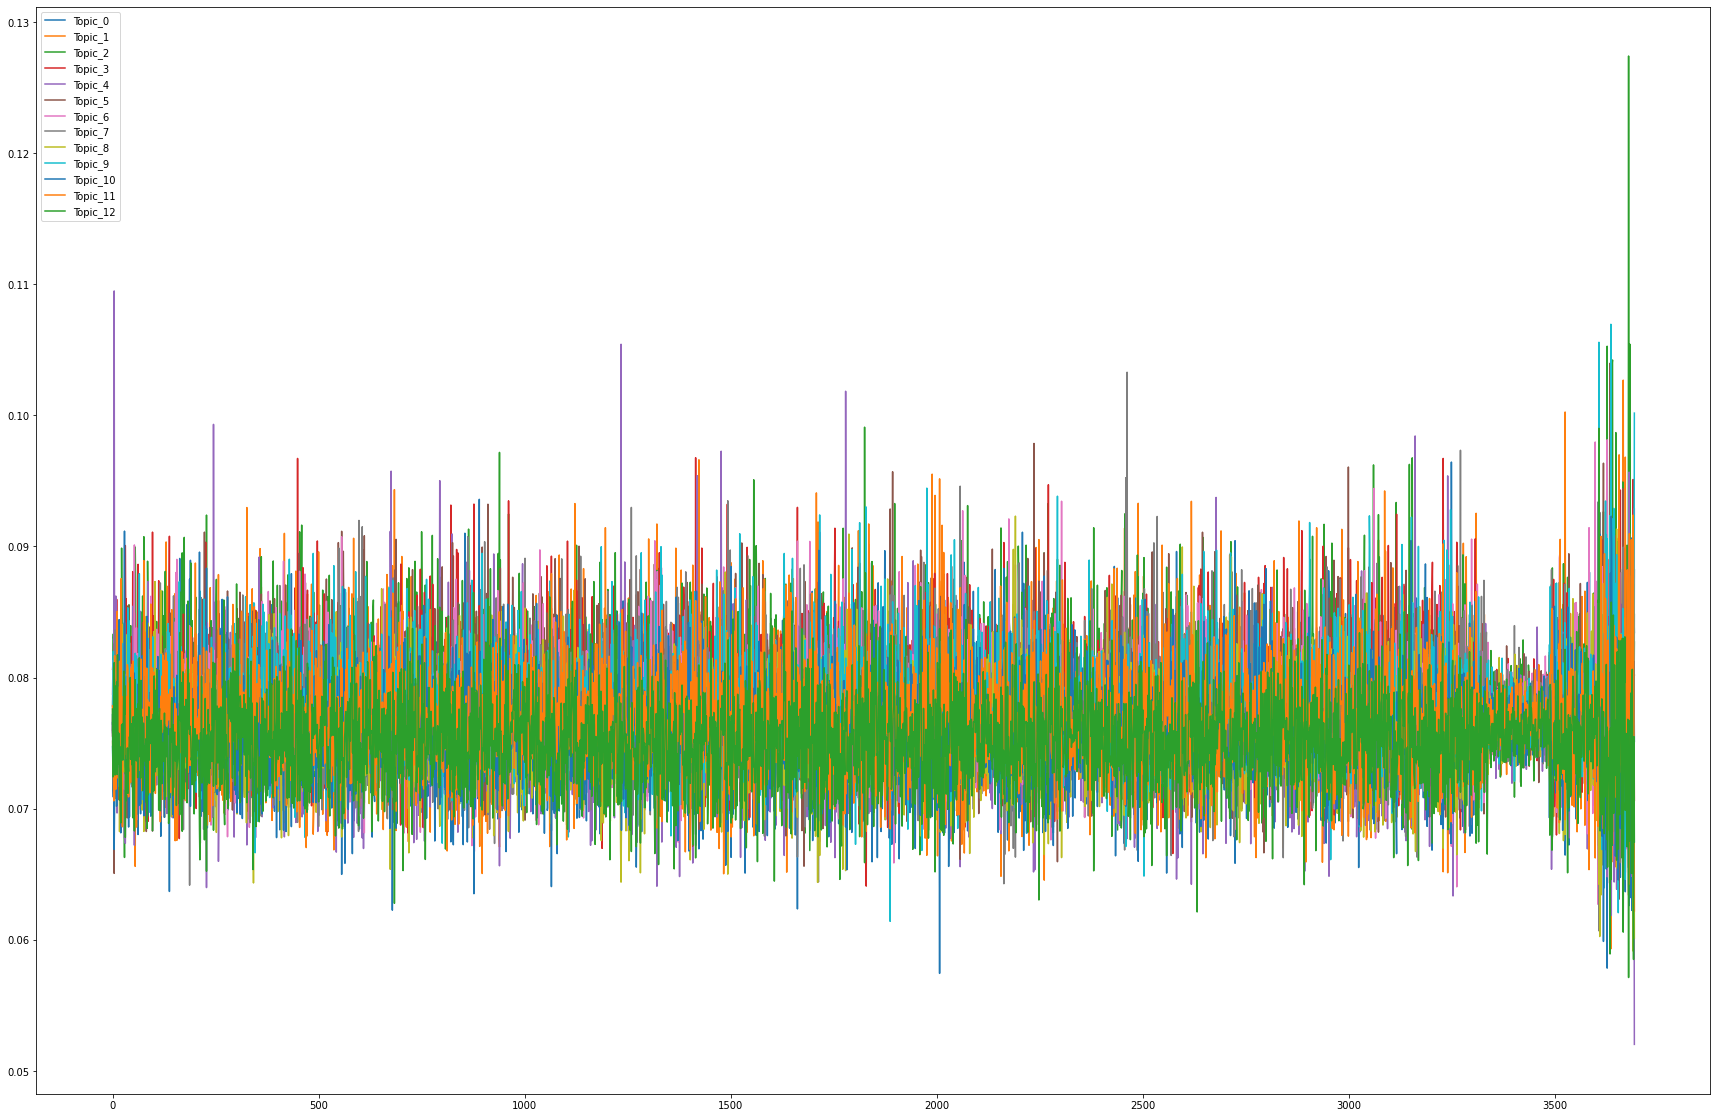

In [34]:
df.plot(figsize=(30,20))

In [35]:
df_document_per_topic.sort_values('Perc_Documents')

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Year,Conf
2071,12,"protocol, scheme, secure, party, computation, ...",83,0.0225,2018,CSS
1438,12,"protocol, scheme, secure, party, computation, ...",83,0.0225,2014,CSS
1160,12,"protocol, scheme, secure, party, computation, ...",83,0.0225,2012,CSS
1924,12,"protocol, scheme, secure, party, computation, ...",83,0.0225,2017,CSS
716,12,"protocol, scheme, secure, party, computation, ...",83,0.0225,2018,Usenix
...,...,...,...,...,...,...
987,2,"analysis, malware, detect, malicious, approach...",621,0.1681,2019,Usenix
2826,2,"analysis, malware, detect, malicious, approach...",621,0.1681,2014,IEEE
2828,2,"analysis, malware, detect, malicious, approach...",621,0.1681,2014,IEEE
2912,2,"analysis, malware, detect, malicious, approach...",621,0.1681,2015,IEEE


Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
Conf Year                                                               
CSS  2011  0.076276  0.077376  0.078038  0.078526  0.075370  0.078945   
     2012  0.076212  0.078115  0.079061  0.078299  0.075506  0.078522   
     2013  0.076323  0.077470  0.078532  0.078329  0.076663  0.078402   
     2014  0.076063  0.078007  0.078990  0.078527  0.075747  0.077361   
     2015  0.076007  0.077899  0.078832  0.077913  0.075925  0.077914   
     2016  0.075529  0.077586  0.078945  0.078500  0.076056  0.077565   
     2017  0.075588  0.077665  0.078938  0.077820  0.076306  0.078197   
     2018  0.076004  0.077421  0.078664  0.078153  0.075506  0.078031   
     2019  0.075795  0.077381  0.079180  0.078179  0.075315  0.077946   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
Conf Year                                                               
CSS  2011  0.077345  0.077222  0.076543  0.077265  0.075113  0.076913   
     2012  0.076986  0.076825  0.075797  0.077415  0.075928  0.076779   
     2013  0.077212  0.076475  0.075545  0.077596  0.075971  0.076703   
     2014  0.077391  0.077480  0.075630  0.077377  0.076077  0.076710   
     2015  0.077688  0.076896  0.075654  0.078024  0.075548  0.076717   
     2016  0.077499  0.077032  0.075566  0.077848  0.075764  0.077095   
     2017  0.077784  0.076776  0.075752  0.077887  0.075523  0.076478   
     2018  0.077216  0.077114  0.075819  0.078012  0.075827  0.076945   
     2019  0.077145  0.076781  0.075754  0.077964  0.076413  0.076770   

           Topic_12  
Conf Year            
CSS  2011  0.075067  
     2012  0.074555  
     2013  0.074779  
     2014  0.074640  
     2015  0.074981  
     2016  0.075018  
     2017  0.075287  
     2018  0.075289  
     2019  0.075376

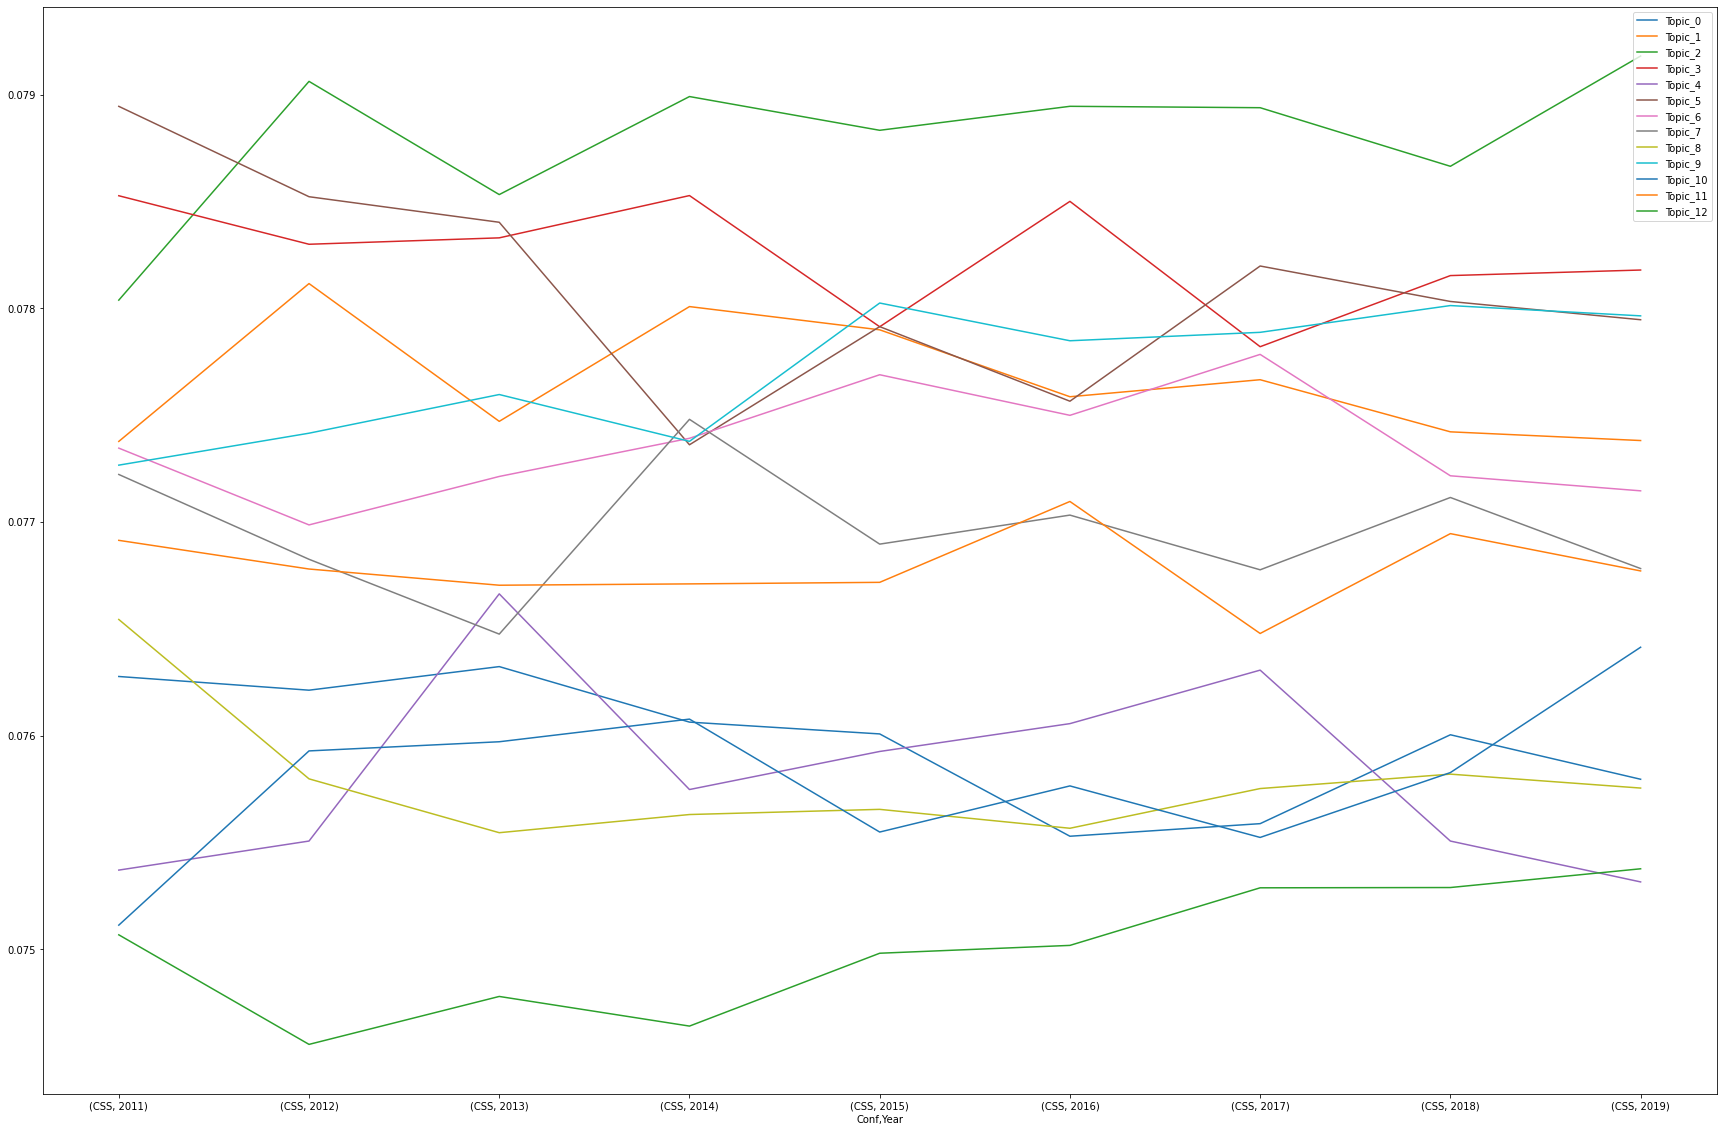

In [77]:
# Topic distribution over year graph for CSS
df_css = df[df['Conf'] == 'CSS'].groupby(['Conf', 'Year']).mean()
df_css.plot(figsize=(30,20))
df_css

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12
Year,,,,,,,,,,,,,
2000,0.076177,0.077701,0.077510,0.077872,0.076103,0.077149,0.076638,0.075895,0.076599,0.078065,0.077453,0.076423,0.076416
2001,0.076960,0.078459,0.079516,0.077950,0.075982,0.077014,0.077741,0.077632,0.075594,0.076704,0.074937,0.076665,0.074846
2002,0.076572,0.076947,0.077443,0.078399,0.075955,0.077921,0.078285,0.075990,0.076420,0.077864,0.076439,0.076770,0.074993
2003,0.076127,0.077314,0.077246,0.078116,0.076036,0.079299,0.078514,0.076888,0.077166,0.075828,0.076871,0.075271,0.075322
2004,0.075809,0.076977,0.078750,0.078249,0.075890,0.079267,0.076869,0.075828,0.076060,0.076633,0.076631,0.077911,0.075124
2005,0.076526,0.078768,0.078941,0.078337,0.074422,0.080202,0.077539,0.077941,0.075399,0.075562,0.076500,0.075917,0.073948
2006,0.076240,0.078242,0.079239,0.077964,0.074619,0.078070,0.077462,0.077392,0.075533,0.077683,0.075865,0.076927,0.074763
2007,0.075717,0.077378,0.079792,0.077223,0.075701,0.077780,0.078466,0.077310,0.076666,0.076191,0.076420,0.076681,0.074675
2008,0.077149,0.077165,0.078333,0.076899,0.075883,0.077566,0.077812,0.078614,0.076254,0.077059,0.075713,0.076606,0.074947


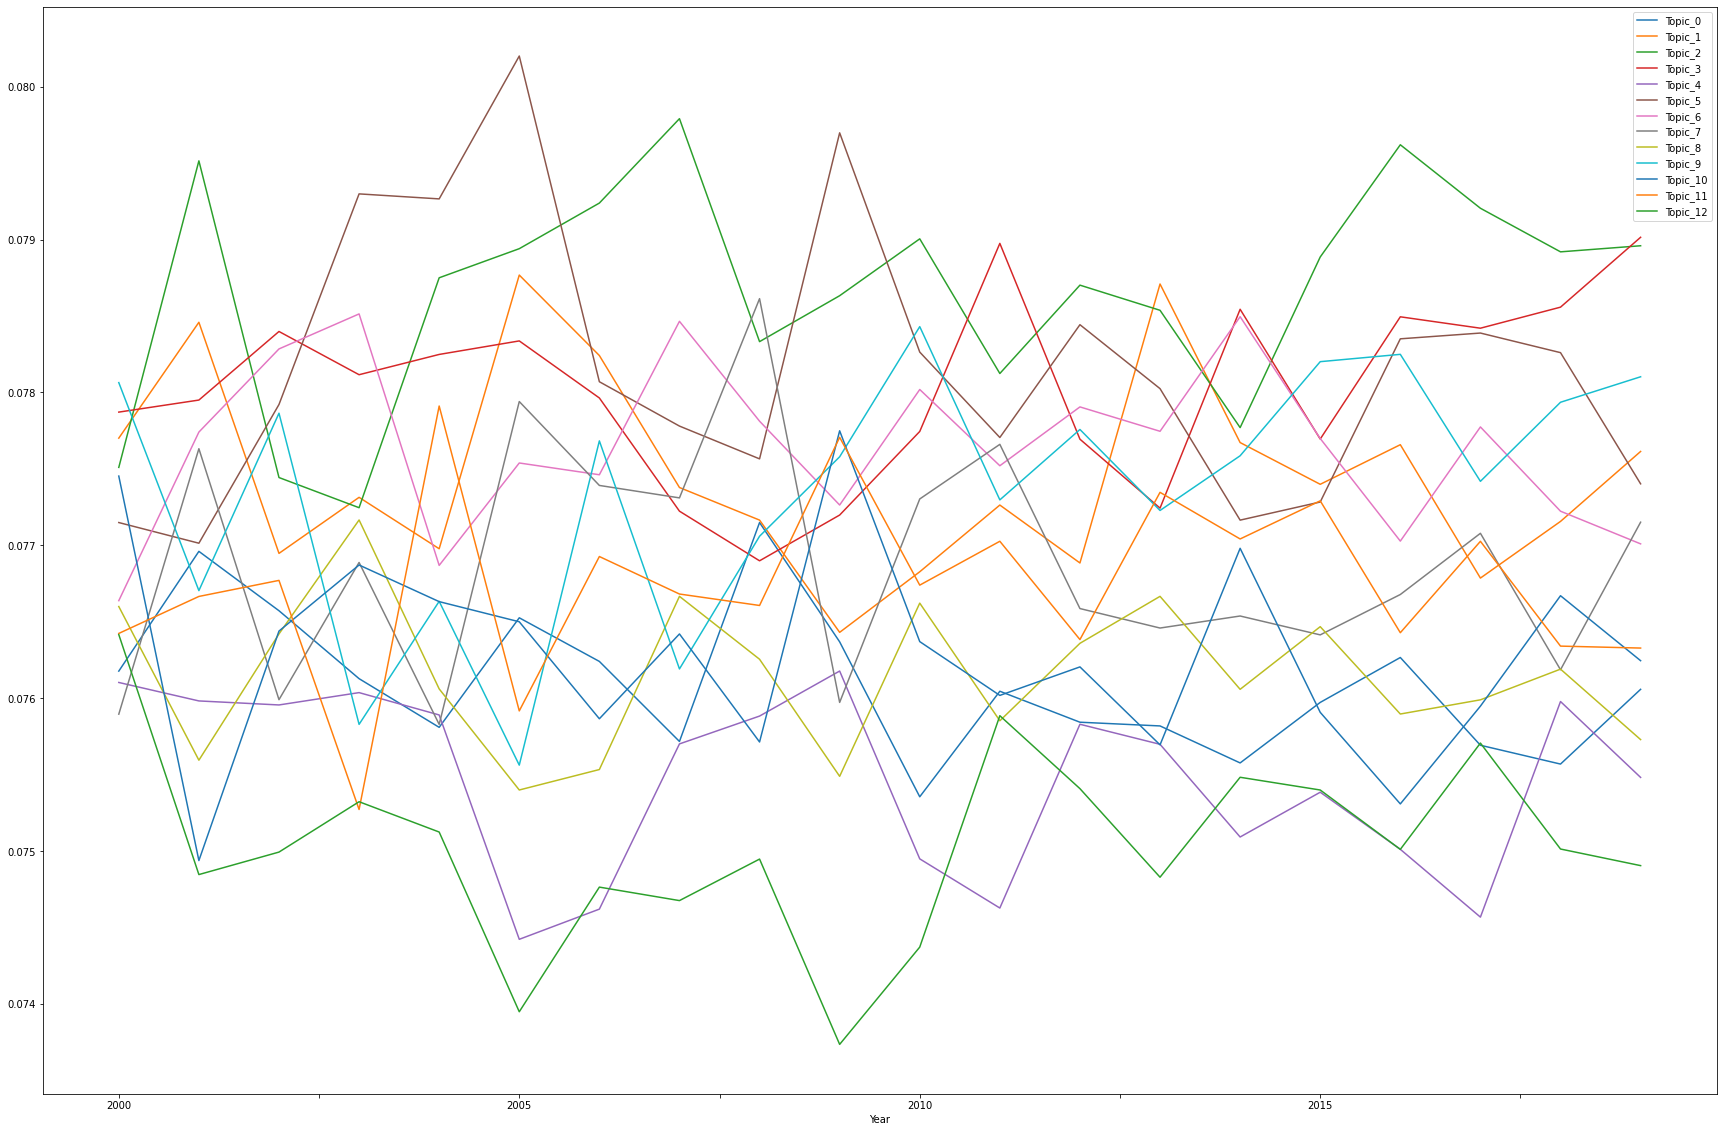

In [79]:
# Topic distribution over year graph for IEEE
df_ieee = df[df['Conf'] == 'IEEE'].groupby(['Year']).mean()
df_ieee.plot(figsize=(30,20))
df_ieee

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12
Year,,,,,,,,,,,,,
2012,0.076272,0.076964,0.079244,0.078562,0.075999,0.078401,0.077280,0.076535,0.076335,0.077339,0.075439,0.076616,0.075014
2013,0.077034,0.076907,0.079326,0.077938,0.075456,0.077709,0.077747,0.076130,0.076652,0.077264,0.076169,0.076992,0.074676
2014,0.076183,0.077237,0.078576,0.077983,0.075801,0.078214,0.077209,0.076804,0.075518,0.077902,0.076124,0.076811,0.075638
2015,0.076235,0.077060,0.079146,0.077858,0.075795,0.078635,0.077368,0.076235,0.076050,0.078406,0.075716,0.076520,0.074976
2016,0.076050,0.076903,0.079049,0.078131,0.075775,0.078143,0.078238,0.076906,0.075415,0.077808,0.075777,0.076531,0.075275
2017,0.075813,0.076299,0.079356,0.078039,0.075479,0.078661,0.077391,0.076967,0.076266,0.077922,0.076003,0.076569,0.075235
2018,0.075865,0.077135,0.078939,0.078417,0.076180,0.078003,0.077134,0.076857,0.076115,0.077609,0.075809,0.076461,0.075477
2019,0.075883,0.076478,0.079297,0.078390,0.075984,0.077694,0.077128,0.076717,0.076138,0.078116,0.076066,0.076228,0.075883


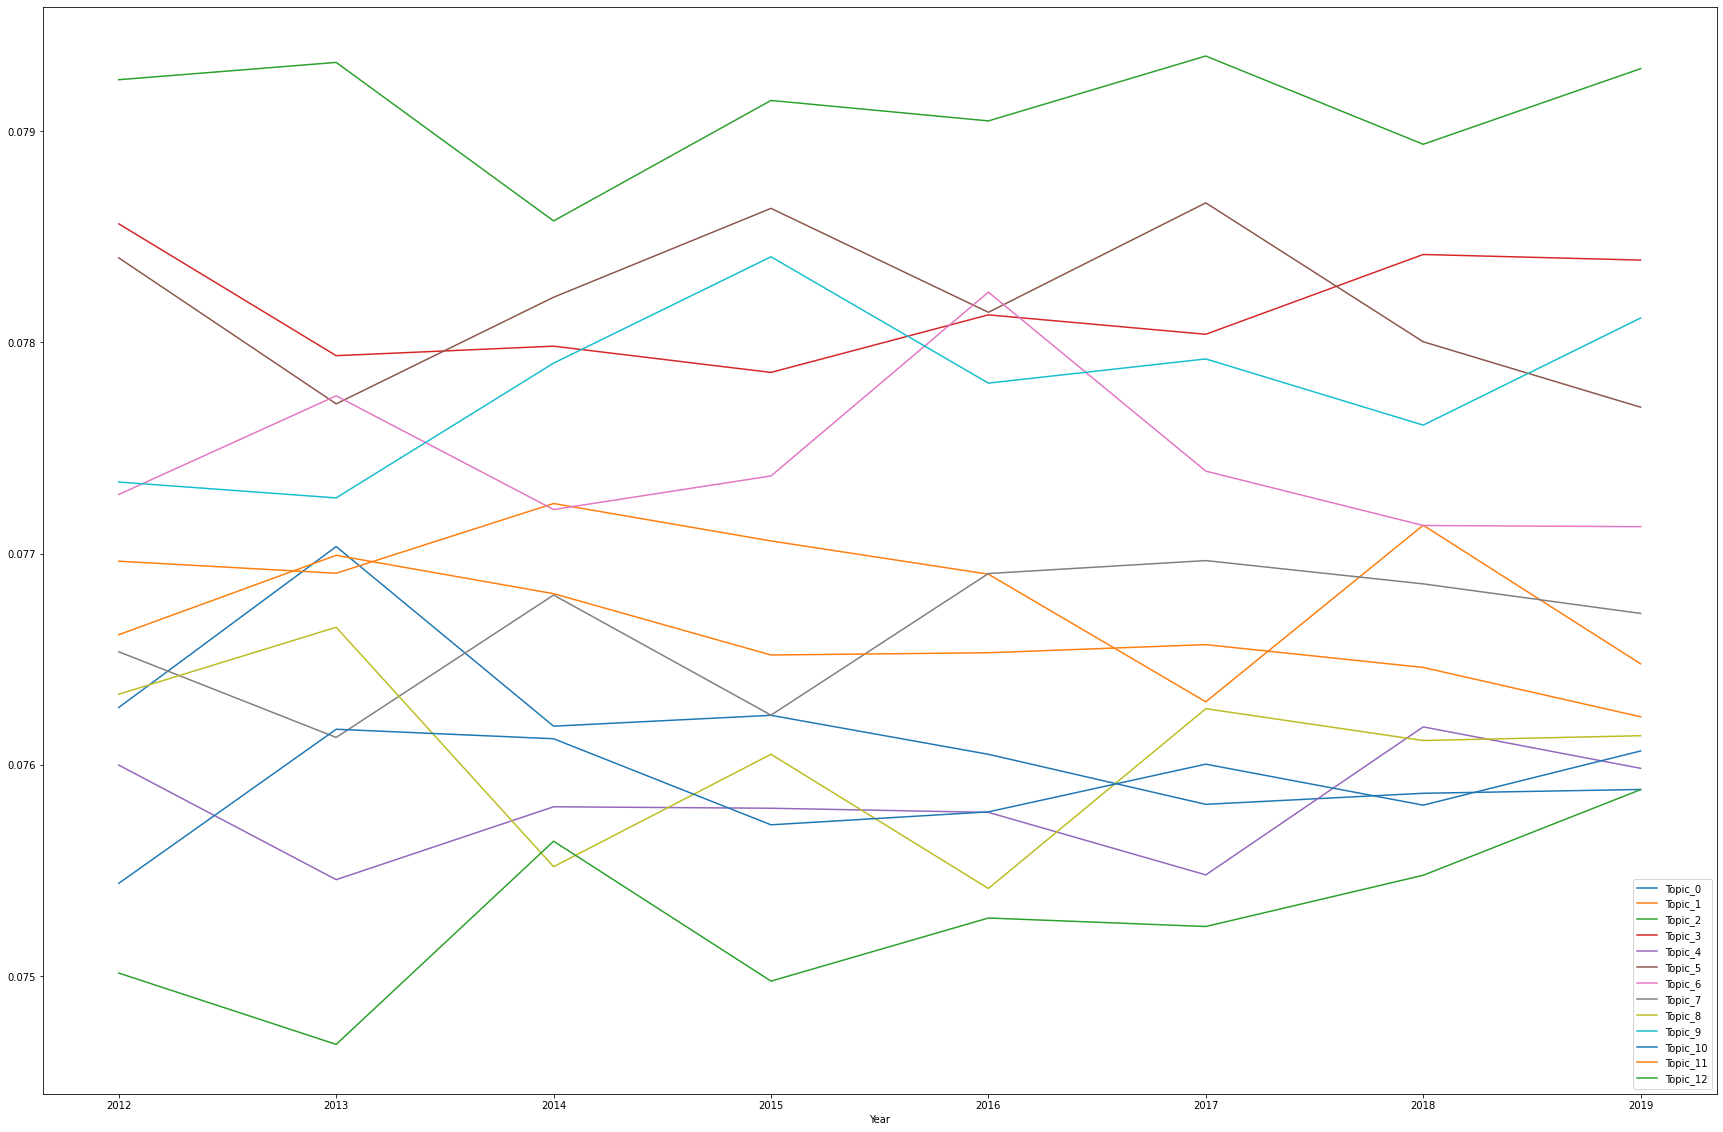

In [83]:
# Topic distribution over year graph for USENIX
df_usenix = df[df['Conf'] == 'Usenix'].groupby(['Year']).mean()
df_usenix.plot(figsize=(30,20))
df_usenix

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12
Year,,,,,,,,,,,,,
2012,0.076693,0.076824,0.077565,0.077251,0.076191,0.077873,0.077025,0.076857,0.077014,0.077152,0.076928,0.076598,0.076029
2013,0.076607,0.077183,0.077778,0.077337,0.076523,0.077346,0.077538,0.077234,0.076888,0.076926,0.076375,0.076703,0.075562
2014,0.076790,0.076877,0.077711,0.076915,0.076851,0.077273,0.077219,0.077077,0.076637,0.077094,0.076562,0.076868,0.076125
2015,0.075633,0.079154,0.078598,0.078188,0.075186,0.078314,0.077315,0.076908,0.075568,0.078646,0.075895,0.076523,0.074071
2016,0.079203,0.074195,0.077937,0.076337,0.075970,0.074363,0.075651,0.079915,0.076835,0.079799,0.076769,0.078203,0.074822
2017,0.076764,0.077642,0.078307,0.077292,0.076037,0.077890,0.078014,0.076431,0.075957,0.077349,0.076243,0.076083,0.075990
2019,0.074595,0.078342,0.081856,0.078462,0.073669,0.079169,0.076764,0.076569,0.074841,0.078970,0.075151,0.077670,0.073944


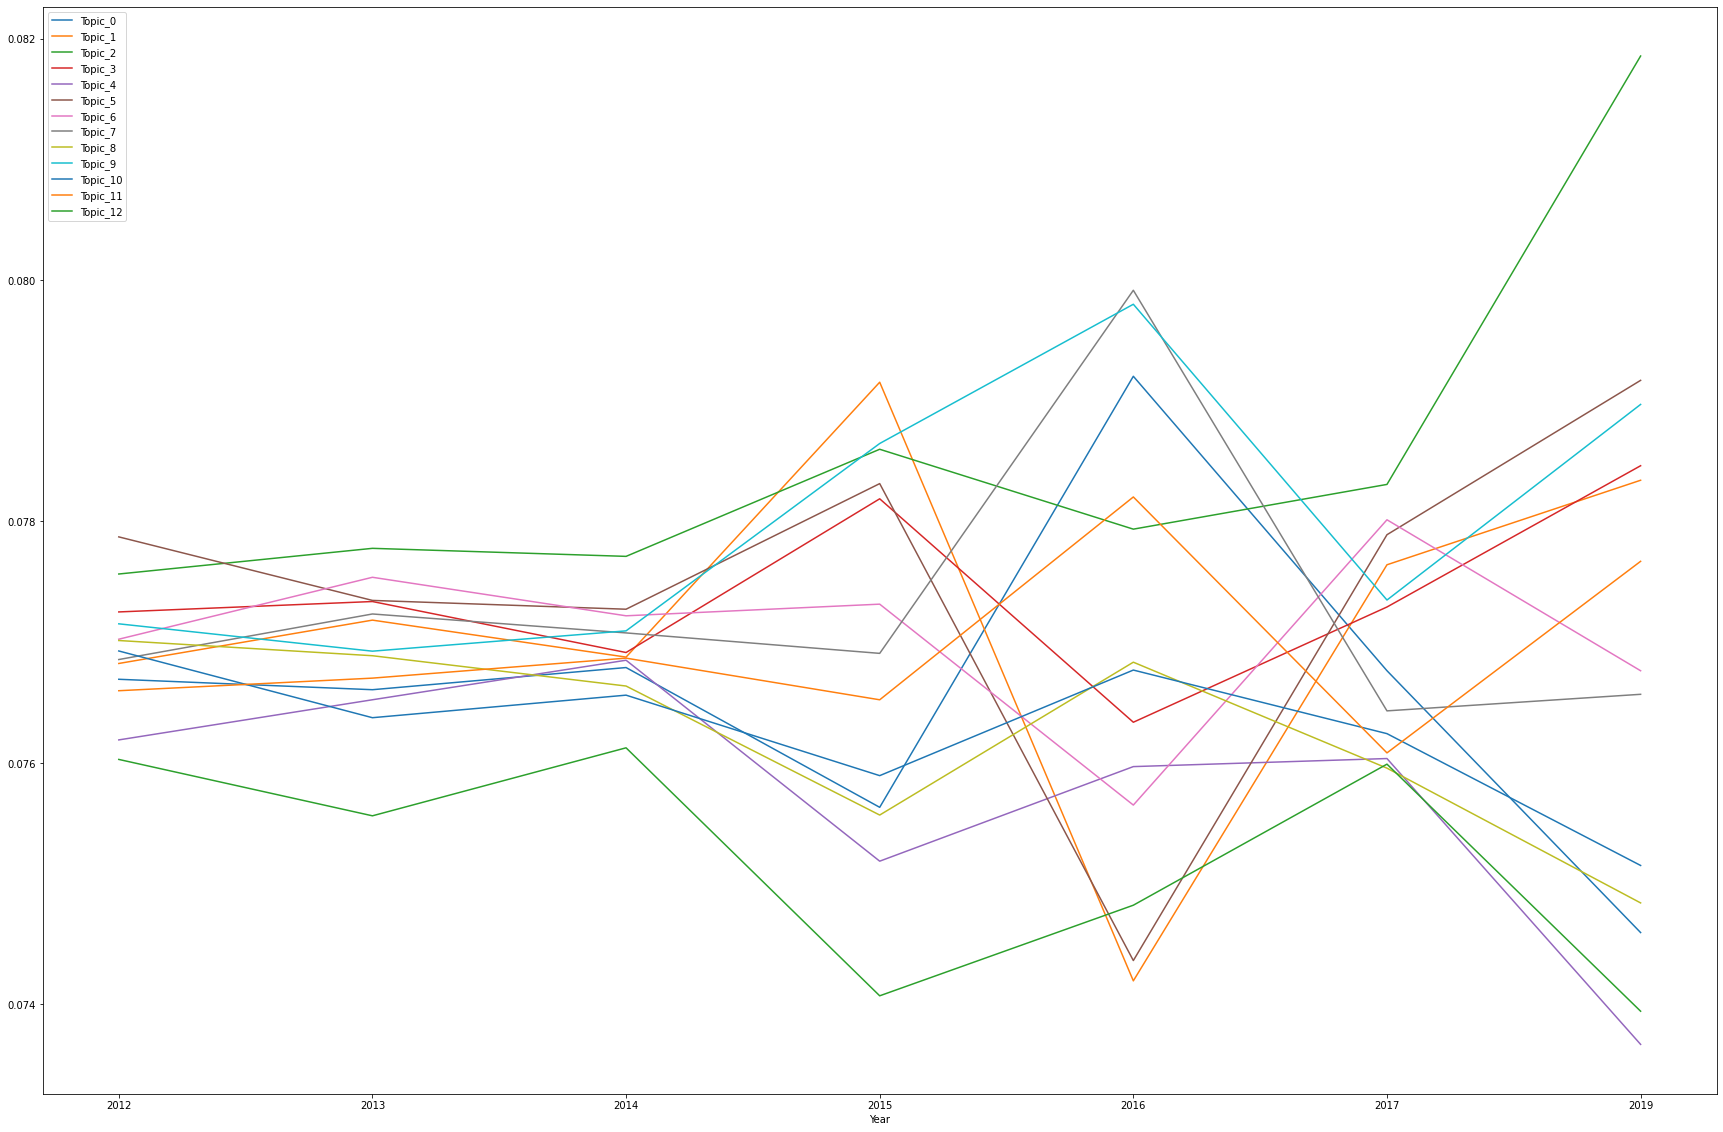

In [85]:
# Topic distribution over year graph for NDSS
df_ndss = df[df['Conf'] == 'NDSS'].groupby(['Year']).mean()
df_ndss.plot(figsize=(30,20))
df_ndss